# This script demonstrates how to build a variational autoencoder with vae_tools

In [1]:
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose
from keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
# resize the notebook if desired
#vae_tools.nb_tools.notebook_resize()
import matplotlib
import matplotlib.pyplot as plt

keras version: 2.2.4
tensorflow version: 1.12.0
matplotlib uses:  module://ipykernel.pylab.backend_inline
Available GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Get the MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

Store model to filename: tmp/myVAE.png and tmp/myVAE.svg
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 1)    5           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   320         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________

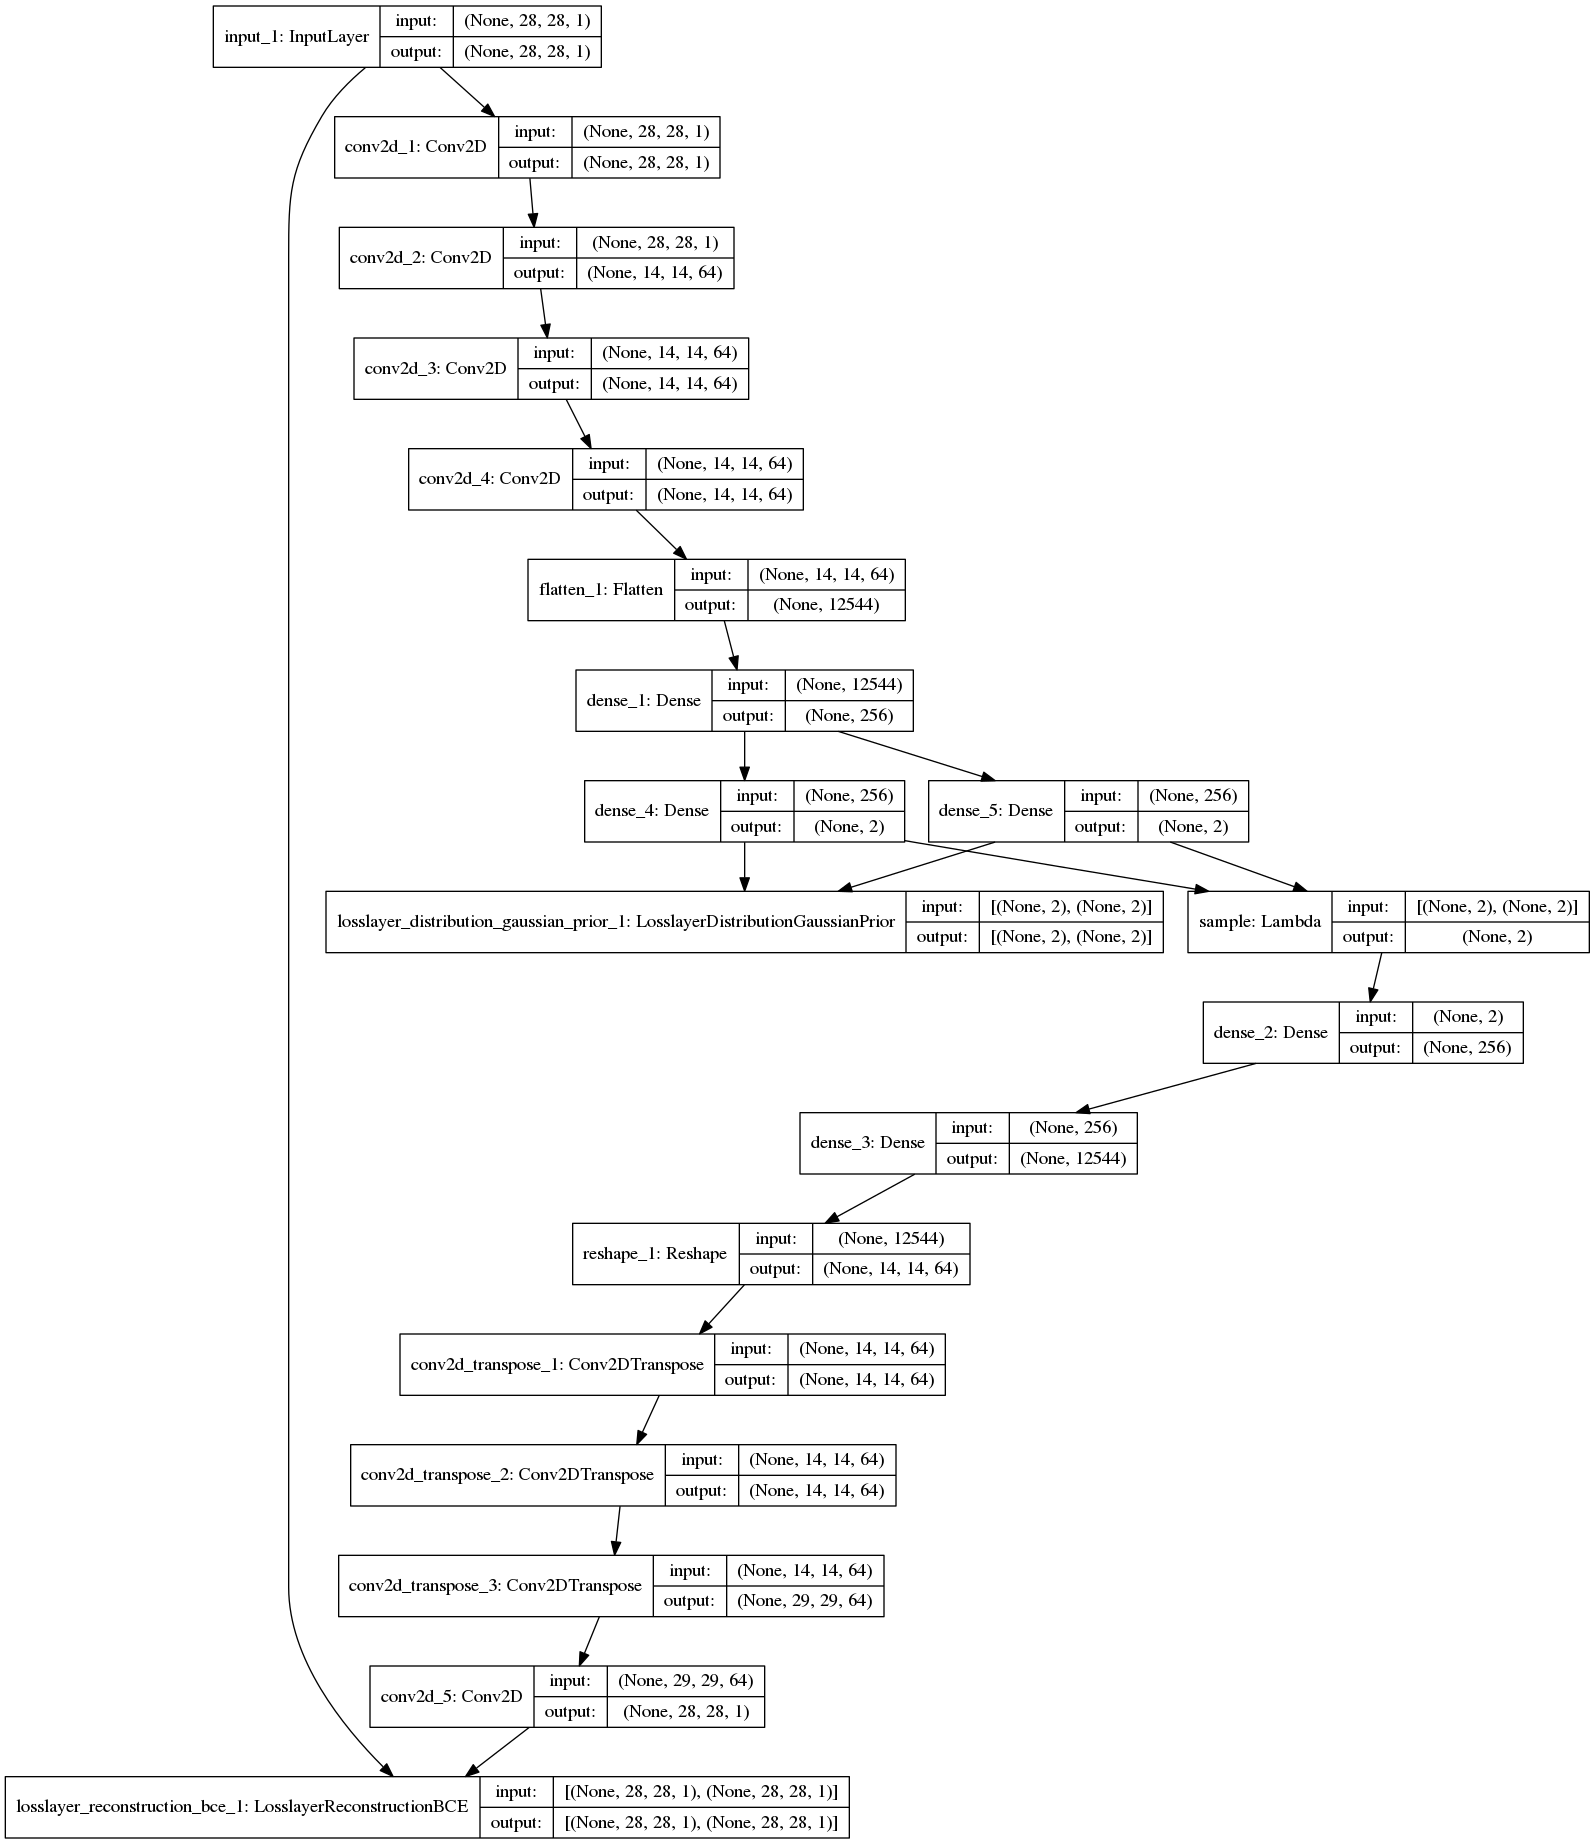

In [3]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
batch_size = 1024
original_dim = img_rows * img_cols * img_chns
intermediate_dim = 256
epochs = 50
z_dim = 2
beta = 1.
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

encoder = [[
    Input(shape=original_img_size),
    Conv2D(img_chns, kernel_size=(2, 2),padding='same', activation='relu'),
    Conv2D(filters, kernel_size=(2, 2), padding='same', activation='relu',strides=(2, 2)),
    Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
    Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1),
    Flatten(),
    Dense(intermediate_dim, activation='relu')
]]

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)
    
decoder = [[
    Dense(intermediate_dim, activation='relu'),
    Dense(filters * 14 * 14, activation='relu'),
    Reshape(output_shape[1:]),
    Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
    Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu'),
    Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu'),
    Conv2D(img_chns, kernel_size=2, padding='valid', activation='sigmoid')
]]

vae_obj = MmVae(z_dim, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [ReconstructionLoss.BCE], name='Vae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

In [4]:
# Store the losses, encodings, and decodings to tensorboard
# It is important to include the native Tensorboard callback as well besides vae_tools.callbacks.Tb*
log_dir = './Graph/mnist_wo_conv'

writer = tf.summary.FileWriter(log_dir) # Get a writer for our own callbacks
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
tblosses_cb = vae_tools.callbacks.TbLosses(writer = writer, data = x_test, log_dir=log_dir)
tbembedding_cb = vae_tools.callbacks.TbEmbedding(writer = writer, data = x_test, encoder_model = vae_obj.get_encoder_mean([encoder[0][0]]), labels = y_test, log_dir=log_dir)
tbdecoding_cb = vae_tools.callbacks.TbDecoding2dGaussian(writer = writer, decoder_model = vae_obj.get_decoder(), log_dir=log_dir)
# Store the losses to a history object for plotting
losses_cb = vae_tools.callbacks.Losses(data = x_test)
# Train
vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose = 0,
            callbacks=[tb_cb, tblosses_cb, tbdecoding_cb, tbembedding_cb, losses_cb])

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (60000, 784)

In [ ]:
# Show the losses
f, axs = plt.subplots(len(list(losses_cb.history.values()))+1, 1, sharex=True, figsize=[10,10], dpi=96)
for idx in range(len(axs)-1):
    axs[idx].plot(list(losses_cb.history.values())[idx])
    axs[idx].set_title([list(losses_cb.history.keys())[idx]])
axs[-1].plot([sum(values) for values in zip(*list(losses_cb.history.values()))])
axs[-1].set_title("ELBO")
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
generator = vae_obj.get_decoder()
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-1-i) * digit_size: ((n-1-i) + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
# build a model to project inputs on the latent space
encoder_input = [encoder[0][0]]
encoder_model = vae_obj.get_encoder_mean(encoder_input)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder_model.predict(x_test, batch_size=batch_size)
f = plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.axis("equal")
plt.show()